# Experiments Results Analysis

In the following notebook we will analyze the preformance of a single SSM (Falcon3-Mamba-7B-Instruct) and a single LLM (Llama-3.1-8B-Instruct).<br>
Those are two instruction models with similar sizes (7.27B vs 8.03B params).<br>
For each model we'll examine the following:
* `gold_index_change` task with 10,20 and 30 documents AND will compare the `openbook_random` and `closedbook` prompting modes.
* `num_docs_change` with gold index of 0,4 and 9 AND will compare the `openbook_random` and `closedbook` prompting modes.

After those are done - we'll compare the SSM and LLM performance.<br>
Additionally, we run the `gold_index_change` with a "non-instruct" falcon model and copare the results with the "instruct" model to the better understand the instruction fine-tuning impact.

## Utils

* matplotlib plots handling
* test results statistics calculation
* test result object loading

In [88]:
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Any

import matplotlib.pyplot as plt
import statistics
import numpy as np
import json
import os

Make sure a local assets/plots folder exists (ignored by git)

In [90]:
os.makedirs("../assets/plots", exist_ok=True)

In [ ]:
def load_test_results(results_file_path: str) -> Dict[str, Any]:
    with open(results_file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [ ]:
def get_scores_mean(scores: List[float], precision: Optional[int] = 4) -> float:
    if precision < 0:
        raise ValueError("'precision' can't be a negative number.")
    return round(statistics.mean(scores), precision)

In [ ]:
def plot_metric_over_documents(
    x_values: List[int],
    y_values_list: List[List[float]],
    series_labels: List[str],
    title: Optional[str] = "Metric over Documents",
    xtitle: Optional[str] = "Gold Index",
    ytitle: Optional[str] = "Metric Mean",
    closedbook_mean: Optional[float] = None,
    closedbook_label: Optional[str] = None,
    figsize: Optional[Tuple[int, int]] = (8, 6),
    image_name: Optional[str] = None
) -> None:

    plt.figure(figsize=figsize)
    
    for y_values, label in zip(y_values_list, series_labels):
        plt.plot(x_values, y_values, marker="o", label=label.lower())

    if closedbook_mean is not None:
        plt.axhline(
            y=closedbook_mean,
            color="red",
            linestyle="--",
            label=closedbook_label or "closedbook"
        )

    plt.xticks(np.arange(min(x_values), max(x_values)+1, 2))

    plt.title(title, weight="bold")
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    plt.tight_layout()
    if image_name is not None:
        plt.savefig(f"../assets/plots/{image_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
def populate_plot_data_lists(
    data: Dict[str, Any],
    scores_eval: List[float],
    x_values: Optional[List[int]] = None,
    num_prompt_tokens: Optional[List[int]] = None,
    sort_keys: Optional[bool] = True,
    show_scores_eval: Optional[bool] = False
) -> str:

    metric = ""
    keys = list(data["experiments"].keys())
    if sort_keys is True:
        keys = sorted(keys, key=lambda x: [int(xi) for xi in x.split("_") if xi.isdigit()][0])

    for key in keys:
        if "gold_at_" in key:
            str_to_replace = "gold_at_"
        elif "_total_documents" in key:
            str_to_replace = "_total_documents"
        else:
            raise ValueError(f"Unidentified results dict key {key}")

        if x_values is not None:
            x_val = int(key.replace(str_to_replace, ""))
            x_values.append(x_val)

        item = data["experiments"][key]
        mean = get_scores_mean(item["scores"])
        scores_eval.append(mean)

        if num_prompt_tokens is not None:
            num_prompt_tokens.extend(item["num_prompt_tokens"])

        if metric == "":
            metric = item["metric"]
        else:
            if item["metric"] != metric:
                raise Exception("Inconsistent results scores metric")

    if show_scores_eval is True:
        print(f"{data['model']} scores:\n{scores_eval}")
    return metric

In [ ]:
def plot_single_model_results_data(
    openbook_path: str,
    closedbook_path: Optional[str] = None,
    image_name: Optional[str] = None,
    show_scores_eval: Optional[bool] = False
) -> None:

    openbook_data = load_test_results(openbook_path)
    openbook_scores_eval = []
    num_prompt_tokens = []
    x_values = []

    metric = populate_plot_data_lists(
        data=openbook_data,
        x_values=x_values,
        scores_eval=openbook_scores_eval,
        num_prompt_tokens=num_prompt_tokens,
        show_scores_eval=show_scores_eval
    )

    closedbook_mean = None
    if closedbook_path is not None:
        closedbook_data = load_test_results(closedbook_path)
        closedbook_scores = closedbook_data["experiments"]["closedbook"]["scores"]
        closedbook_mean = get_scores_mean(closedbook_scores)

    # cuts the HuggingFace repo and leaves only the model name
    short_model_name = openbook_data["model"].split("/")[-1]
    experiment_type = openbook_data["experiment_type"]
    
    if experiment_type == "gold_idx_change":
        num_docs = openbook_data["num_documents"]
        graph_title = f"{short_model_name}\n" \
            + f"{experiment_type} with {num_docs} total documents, " \
            + f"Avg prompt length: {round(statistics.mean(num_prompt_tokens), 2)} tokens"
    else:
        gold_idx = openbook_data["gold_index"]
        graph_title = f"{short_model_name}\n" \
            + f"{experiment_type} with gold index {gold_idx}"
    ytitle = f"Performance\n[metric: {metric}]"

    plot_metric_over_documents(
        x_values=x_values,
        y_values_list=[openbook_scores_eval],
        series_labels=[short_model_name.lower()],
        title=graph_title,
        xtitle=(
            "Gold Index [document with answer]"
            if experiment_type == "gold_idx_change"
            else "Number of Documents" 
        ),
        ytitle=ytitle,
        closedbook_mean=closedbook_mean,
        image_name=image_name
    )

In [ ]:
def validate_models_data_consistency(data: List[Any], param_name: str) -> None:
    if data[0] != data[-1]:
        raise Exception(f"Can't compare two model performance of different {param_name}")

In [ ]:
def plot_two_models_comparison(
    openbook_paths: List[str],
    closedbook_path: Optional[str] = None,
    closedbook_label: Optional[str] = None,
    image_name: Optional[str] = None,
    show_scores_eval: Optional[bool] = False
) -> None:
    
    openbook_datas = [load_test_results(openbook_path) for openbook_path in openbook_paths]
    openbook_scores_evals = [[], []]
    x_values = []
    metrics = []

    for i in range(2):
        metric = populate_plot_data_lists(
            data=openbook_datas[i],
            x_values=x_values if i == 0 else None,
            scores_eval=openbook_scores_evals[i],
            show_scores_eval=show_scores_eval
        )
        metrics.append(metric)

    validate_models_data_consistency(data=metrics, param_name="metrics")

    short_model_names = []
    experiment_types = []
    num_docs_list = []
    for openbook_data in openbook_datas:
        experiment_type = openbook_data["experiment_type"]
        # cuts the HuggingFace repo and leaves only the model name
        short_model_names.append(openbook_data["model"].split("/")[-1])
        experiment_types.append(experiment_type)
        if experiment_type == "gold_idx_change":
            num_docs_list.append(openbook_data["num_documents"])

    validate_models_data_consistency(data=experiment_types, param_name="experiments")

    closedbook_mean = None
    if closedbook_path is not None:
        closedbook_data = load_test_results(closedbook_path)
        closedbook_scores = closedbook_data["experiments"]["closedbook"]["scores"]
        closedbook_mean = get_scores_mean(closedbook_scores)

    if num_docs_list:
        graph_title = f"{short_model_names[0]} vs {short_model_names[-1]}\n" \
            + f"{experiment_types[0]} with {num_docs_list[0]} total documents"
        xtitle = "Gold Index [document with answer]"
    else:
        graph_title = f"{short_model_names[0]} vs {short_model_names[-1]}\n" \
            + f"{experiment_types[0]} with gold index {openbook_datas[0]["gold_index"]}"
        xtitle = "Number of Documents"
    ytitle = f"Performance\n[metric: {metrics[0]}]"

    plot_metric_over_documents(
        x_values=x_values,
        y_values_list=openbook_scores_evals,
        series_labels=short_model_names,
        title=graph_title,
        xtitle=xtitle,
        ytitle=ytitle,
        closedbook_mean=closedbook_mean,
        closedbook_label=closedbook_label,
        image_name=image_name
    )

### Utils tests

In [ ]:
test_file_path = list(Path("./results").rglob(f"*json"))[0]
results = load_test_results(test_file_path)
results

In [ ]:
get_scores_mean(results["experiments"]["gold_at_0"]["scores"])

In [ ]:
plot_metric_over_documents([0, 4, 9], [[0.6, 0.4, 0.5]], ["falcon-mamaba"], closedbook_mean=0.42)

In [ ]:
plot_metric_over_documents([0, 4, 9], [[0.6, 0.4, 0.5], [0.67, 0.58, 0.61]], ["falcon-mamaba", "llama-31"])

## Falcon3-Mamba-7B-Instruct Analysis (SSM)

### Gold Index change

In [ ]:
falcon_closedbook_path = "../results/Falcon3-Mamba-7B-Instruct/gold_idx_change_experiment/closedbook_prompting_mode"
falcon_closedbook_file = list(Path(falcon_closedbook_path).glob(f"*json"))[0]
falcon_openbook_path = "../results/Falcon3-Mamba-7B-Instruct/gold_idx_change_experiment/openbook_prompting_mode"

10 total documents

In [ ]:
falcon_openbook_file_10_docs = list(Path(f"{falcon_openbook_path}/10_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_openbook_file_10_docs,
    closedbook_path=falcon_closedbook_file
)

20 total documents

In [ ]:
falcon_openbook_file_20_docs = list(Path(f"{falcon_openbook_path}/20_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_openbook_file_20_docs,
    closedbook_path=falcon_closedbook_file
)

30 total documents

In [ ]:
falcon_openbook_file_30_docs = list(Path(f"{falcon_openbook_path}/30_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_openbook_file_30_docs,
    closedbook_path=falcon_closedbook_file
)

### Input Documents Increase

In [ ]:
falcon_openbook_path = "../results/Falcon3-Mamba-7B-Instruct/num_docs_change_experiment/openbook_prompting_mode"
falcon_closedbook_path = "../results/Falcon3-Mamba-7B-Instruct/gold_idx_change_experiment/closedbook_prompting_mode"
falcon_closedbook_file = list(Path(falcon_closedbook_path).glob(f"*json"))[0]

gold at index 0

In [ ]:
falcon_openbook_file_gold_idx_0 = list(Path(f"{falcon_openbook_path}/gold_idx_0").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_openbook_file_gold_idx_0,
    closedbook_path=falcon_closedbook_file
)

gold at index 4

In [ ]:
falcon_openbook_file_gold_idx_4 = list(Path(f"{falcon_openbook_path}/gold_idx_4").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_openbook_file_gold_idx_4,
    closedbook_path=falcon_closedbook_file
)

gold at index 9

In [ ]:
falcon_openbook_file_gold_idx_9 = list(Path(f"{falcon_openbook_path}/gold_idx_9").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_openbook_file_gold_idx_9,
    closedbook_path=falcon_closedbook_file
)

## Llama-3.1-8B-Instruct Analysis (LLM)

### Gold Index Change

In [ ]:
llama_closedbook_path = "../results/Llama-3.1-8B-Instruct/gold_idx_change_experiment/closedbook_prompting_mode"
llama_closedbook_file = list(Path(llama_closedbook_path).glob(f"*json"))[0]
llama_openbook_path = "../results/Llama-3.1-8B-Instruct/gold_idx_change_experiment/openbook_prompting_mode"

10 total documents

In [ ]:
llama_openbook_file_10_docs = list(Path(f"{llama_openbook_path}/10_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=llama_openbook_file_10_docs,
    closedbook_path=llama_closedbook_file
)

20 total documents

In [ ]:
llama_openbook_file_20_docs = list(Path(f"{llama_openbook_path}/20_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=llama_openbook_file_20_docs,
    closedbook_path=llama_closedbook_file
)

30 total documents

In [ ]:
llama_openbook_file_30_docs = list(Path(f"{llama_openbook_path}/30_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=llama_openbook_file_30_docs,
    closedbook_path=llama_closedbook_file
)

### Input Documents Increase

In [ ]:
llama_openbook_path = "../results/Llama-3.1-8B-Instruct/num_docs_change_experiment/openbook_prompting_mode"
llama_closedbook_path = "../results/Llama-3.1-8B-Instruct/gold_idx_change_experiment/closedbook_prompting_mode"
llama_closedbook_file = list(Path(llama_closedbook_path).glob(f"*json"))[0]

gold at index 0

In [ ]:
llama_openbook_file_gold_idx_0 = list(Path(f"{llama_openbook_path}/gold_idx_0").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=llama_openbook_file_gold_idx_0,
    closedbook_path=falcon_closedbook_file
)

gold at index 4

In [ ]:
llama_openbook_file_gold_idx_4 = list(Path(f"{llama_openbook_path}/gold_idx_4").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=llama_openbook_file_gold_idx_4,
    closedbook_path=falcon_closedbook_file
)

gold at index 9

In [ ]:
llama_openbook_file_gold_idx_9 = list(Path(f"{llama_openbook_path}/gold_idx_9").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=llama_openbook_file_gold_idx_9,
    closedbook_path=falcon_closedbook_file
)

## Falcon - Llama Comparison (SSM vs LLM)

### Gold Index Change

10 total documents

In [ ]:
plot_two_models_comparison(
    openbook_paths=[falcon_openbook_file_10_docs, llama_openbook_file_10_docs],
    closedbook_path=falcon_closedbook_file,
    closedbook_label="falcon-mamba-closedbook",
    image_name="falcon-mamba-vs-llama-10-docs",
    show_scores_eval=True
)

20 total documents

In [ ]:
plot_two_models_comparison(
    openbook_paths=[falcon_openbook_file_20_docs, llama_openbook_file_20_docs],
    closedbook_path=falcon_closedbook_file,
    closedbook_label="falcon-mamba-closedbook",
    image_name="falcon-mamba-vs-llama-20-docs",
    show_scores_eval=True
)

30 total documents

In [ ]:
plot_two_models_comparison(
    openbook_paths=[falcon_openbook_file_30_docs, llama_openbook_file_30_docs],
    closedbook_path=falcon_closedbook_file,
    closedbook_label="falcon-mamba-closedbook",
    image_name="falcon-mamba-vs-llama-30-docs",
    show_scores_eval=True
)

### Input Documents Increase

gold at index 0

tiiuae/Falcon3-Mamba-7B-Instruct scores:
[0.594, 0.4614, 0.3981]
meta-llama/Llama-3.1-8B-Instruct scores:
[0.7465, 0.7141, 0.6874]


FileNotFoundError: [Errno 2] No such file or directory: '../assets/plots/falcon-mamba-vs-llama-gold-idx-0.png'

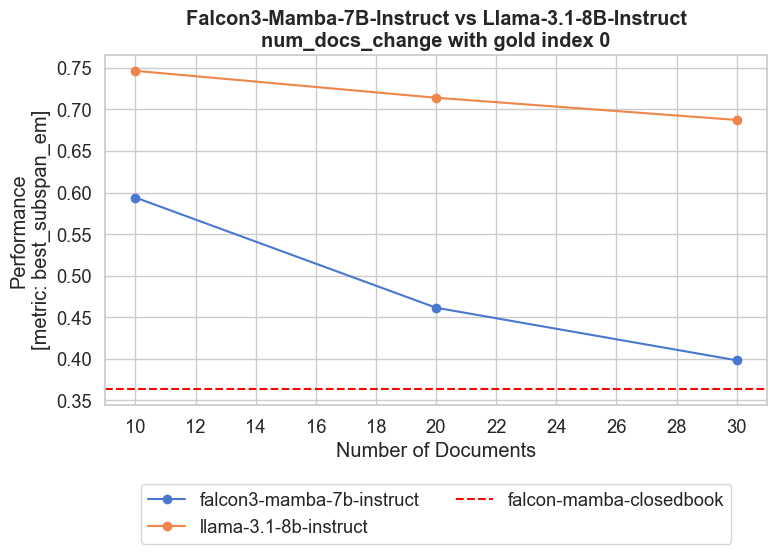

In [86]:
plot_two_models_comparison(
    openbook_paths=[falcon_openbook_file_gold_idx_0, llama_openbook_file_gold_idx_0],
    closedbook_path=falcon_closedbook_file,
    closedbook_label="falcon-mamba-closedbook",
    image_name="falcon-mamba-vs-llama-gold-idx-0",
    show_scores_eval=True
)

gold at index 4

In [ ]:
plot_two_models_comparison(
    openbook_paths=[falcon_openbook_file_gold_idx_4, llama_openbook_file_gold_idx_4],
    closedbook_path=falcon_closedbook_file,
    closedbook_label="falcon-mamba-closedbook",
    image_name="falcon-mamba-vs-llama-gold-idx-4",
    show_scores_eval=True
)

gold at index 9

In [ ]:
plot_two_models_comparison(
    openbook_paths=[falcon_openbook_file_gold_idx_9, llama_openbook_file_gold_idx_9],
    closedbook_path=falcon_closedbook_file,
    closedbook_label="falcon-mamba-closedbook",
    image_name="falcon-mamba-vs-llama-gold-idx-9",
    show_scores_eval=True
)

## Falcon3-Mamba-7B-Base Analysis (SSM)

### Gold Index Change

In [ ]:
falcon_base_closedbook_path = "../results/Falcon3-Mamba-7B-Base/gold_idx_change_experiment/closedbook_prompting_mode"
falcon_base_closedbook_file = list(Path(falcon_base_closedbook_path).glob(f"*json"))[0]
falcon_base_openbook_path = "../results/Falcon3-Mamba-7B-Base/gold_idx_change_experiment/openbook_prompting_mode"

10 total documents

In [ ]:
falcon_base_openbook_file_10_docs = list(Path(f"{falcon_base_openbook_path}/10_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_base_openbook_file_10_docs,
    closedbook_path=falcon_base_closedbook_file
)

20 total documents

In [ ]:
falcon_base_openbook_file_20_docs = list(Path(f"{falcon_base_openbook_path}/20_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_base_openbook_file_20_docs,
    closedbook_path=falcon_base_closedbook_file
)

30 total documents

In [ ]:
falcon_base_openbook_file_30_docs = list(Path(f"{falcon_base_openbook_path}/30_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_base_openbook_file_30_docs,
    closedbook_path=falcon_base_closedbook_file
)

## Falcon Base - Instruct Comparison

### Gold Index Change

10 total documents

In [ ]:
plot_two_models_comparison([falcon_openbook_file_10_docs, falcon_base_openbook_file_10_docs],
    closedbook_path=falcon_closedbook_file,
    closedbook_label="falcon-mamba-instruct-closedbook",
    image_name="falcon-mamba-instruct-vs-base-10-docs",
    show_scores_eval=True
)

20 total documents

In [ ]:
plot_two_models_comparison([falcon_openbook_file_20_docs, falcon_base_openbook_file_20_docs],
    closedbook_path=falcon_closedbook_file,
    closedbook_label="falcon-mamba-instruct-closedbook",
    image_name="falcon-mamba-instruct-vs-base-20-docs",
    show_scores_eval=True
)

30 total documents

In [ ]:
plot_two_models_comparison([falcon_openbook_file_30_docs, falcon_base_openbook_file_30_docs],
    closedbook_path=falcon_closedbook_file,
    closedbook_label="falcon-mamba-instruct-closedbook",
    image_name="falcon-mamba-instruct-vs-base-30-docs",
    show_scores_eval=True
)